## Lattice-Based Cryptography

In this Lab we will implement a simplified version of the NTRU Encryption system as presented in the lecture.

In the second part we'll have a demonstration of the GGH cryptosystem in two dimensions to get a better intuition and understanding.
As always, there are a few questions for you to answer at the end of each task.

## Task 1: NTRU ##

### Key generation ###

In this first part, we will implement the key generation function keygen($N, p, q, d$)

First, write a function that checks if a set of public parameters $N, p, q, d$ is admissable for use with NTRU.

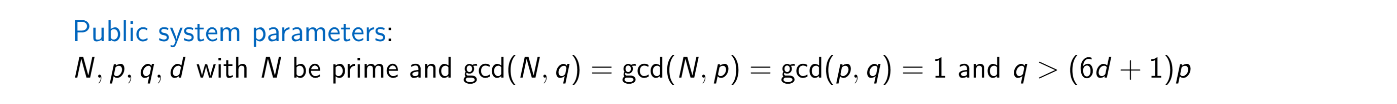

In [1]:
def NTRU_param_check(N, p, q, d):
    if gcd(p,q) != 1:
        return False
    if not (q > ((6*d+1)*p)):
        return False
    if not is_prime(N):
        return False
    return True

In [2]:
### Test cases - do not modify ###
assert (NTRU_param_check(103, 3, 119, 5) == True), "a valid parameter set was rejected."
assert (NTRU_param_check(7, 3, 41, 2) == True), "a valid parameter set was rejected."
assert (NTRU_param_check(110, 3, 119, 5) == False), "an invalid parameter set was accepted."
assert (NTRU_param_check(103, 3, 93, 5) == False), "an invalid parameter set was accepted."


Next, we want to implement the key generation as described in the lecture given a valid parameter set.

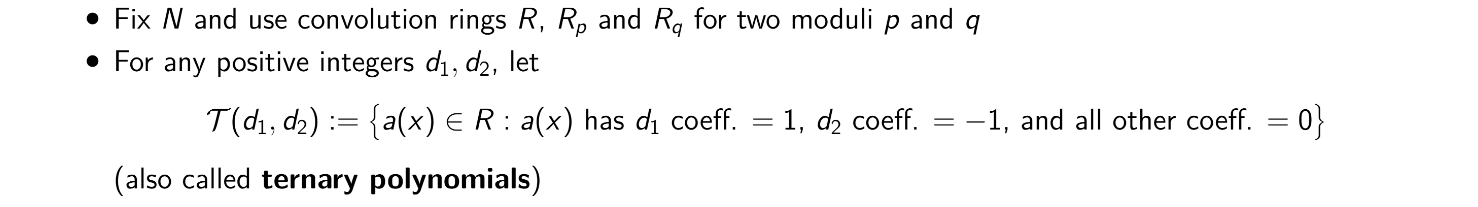

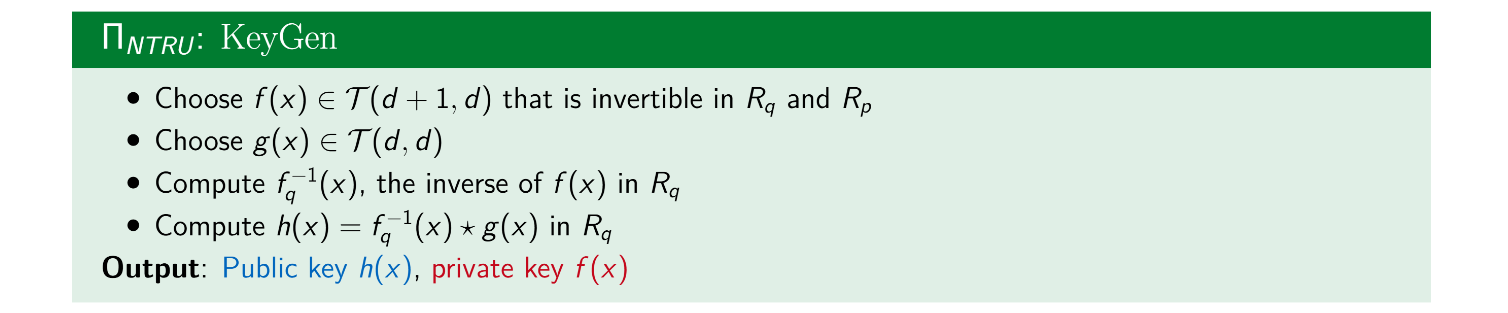

Note that the implementation for the quotient rings $R$, $R_q$ and $R_p$ is already given.
We additionally provid two helper functions:
- invert($u$) computes the inverse of a polynomial $u$ in $R_{q}$ or $R_p$.
- draw_from_T($d_1$, $d_2$) draws a ternary polynomial from R uniformly at random.

In [3]:
### do not modify this part ######
### our chosen NTRU parameters ###
N = 103
p = 3
q = 119
d = 5

# set up integer and poly quotient rings
Zp = Integers(p)
Zq = Integers(q)

R.<x> = PolynomialRing(ZZ)
R.<x> = R.quotient(x^N-1)

Rp.<y> = PolynomialRing(Zp)
Rp.<y> = Rp.quotient(y^N-1)

Rq.<z> = PolynomialRing(Zq)
Rq.<z> = Rq.quotient(z^N-1)

def invert(u):
    """
    Input: polynomial u, an element in S=Rq[a] or S=Rp[a]
    Output: the inverse of u in Rq or Rp. returns 0 if no inverse exists.
    """
    S = parent(u)
    Rz = S.cover_ring()
    z3 = Rz.gen()
    R = Rz.base_ring()
    P = S(u).charpoly(z3)
    mu = R.order()
    d0 = ZZ(P[0])
    d1 = xgcd(d0,mu)[1]
    d2 = R(d1)
    Q = ZZ['z3'](P)
    v = ZZ['z3']((Q - Q[0])*ZZ(d2))//z3
    return S(-v(u))

def draw_from_T(d1, d2):
    """
    Input: integers d1, d2
    Output: a polynomial in R with d1 coefficients equal to 1 and d2 coefficients equal to -1
    """
    a_list = [0]*N
    positions = sample(range(N),d1+d2)
    for ii in positions[:d1]:
        a_list[ii] = 1
    for ii in positions[d1:]:
        a_list[ii] = -1
    a_x = R(a_list)
    return a_x

In [4]:
def NTRU_keygen(N, p, q, d):
    # input N, p, q, d
    # output pk = h(x), sk = f(x)
    
    while True:
        f = draw_from_T(d+1,d)
        fp = Rp(f.list())
        fq = Rq(f.list())
        inv_fq = invert(fq)
        inv_fp = invert(fp)
        if inv_fq != 0 and inv_fp != 0:
            break
    g = draw_from_T(d,d)
    h = inv_fq * Rq(g.list())
    h_x = h
    f_x = f
    
    return h_x, f_x

In [5]:
### test cases ###
t_pk, t_sk = NTRU_keygen(N, p, q, d)

assert invert(Rp(t_sk.list())) != 0 and invert(Rq(t_sk.list())) != 0
assert t_sk.list().count(1) == d+1, "secret key is not valid"
assert t_sk.list().count(-1) == d, "secret key is not valid"
assert parent(t_pk) == Rq, "public is not an element of Rq"

### Encryption ###

Next, we will implement the encryption operation:

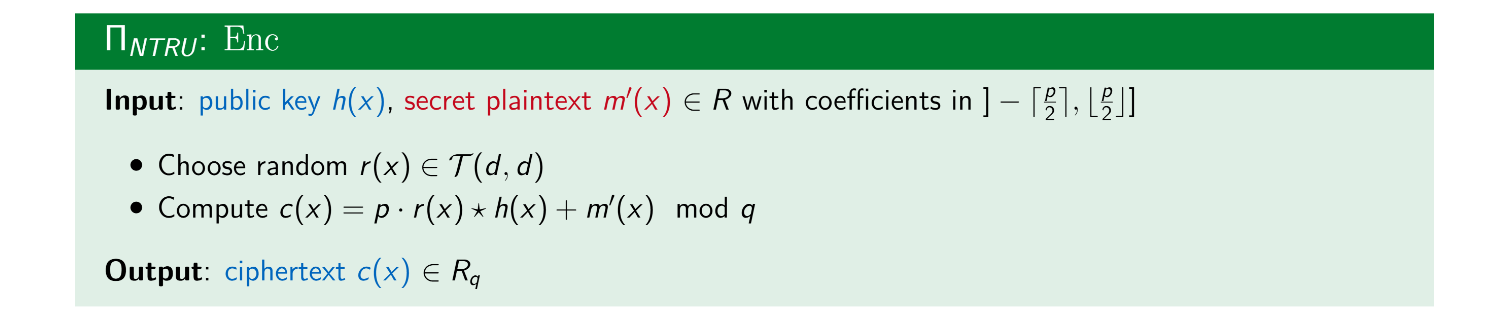

First, let's draw a random message $m'$ from $R$ that fulfills the NTRU requirements:

In [6]:
import random

def NTRU_random_message(R, p):
    m = [randint(1-ceil(p/2),floor(p/2)) for i in range(N)]
    m = R(m)
    m_x = m
    
    return m_x

In [7]:
### test cases ###
t_m = NTRU_random_message(R, p)
assert all([c in [-1,0,1] for c in t_m.list()]), 'message is not a ternary polynomial'
assert t_m in R, 'message is not an element of the quotient ring R'

Next, define the encryption operation which turns an admissable plaintext into a ciphertext polynomial in $R_q$

In [8]:
def NTRU_encrypt(pk, m):
    # input: public key pk = h(x) in Rq, m in R
    # output: ciphertext c(x) in Rq
    
    r = draw_from_T(d,d)
    c = p * Rq(r.list()) * pk + Rq(m.list())
    c_x = c

    return c_x

In [9]:
### test cases ###
t_c = NTRU_encrypt(t_pk, t_m)
assert t_c in Rq, "ciphertext should be a polynomial in Rq"

### Decryption ###

Finally, we'll implement the decryption operation:

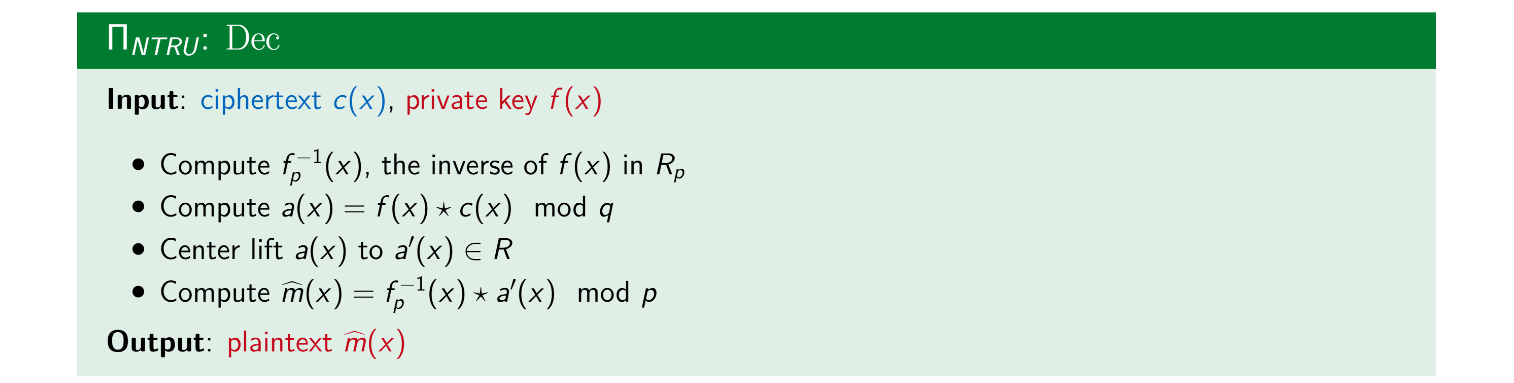

In [10]:
def NTRU_decrypt(c, sk):
    # input: c(x) in Rq, f(x) in R
    # output: m_hat(x) in Rp
    
    fp = Rp(sk.list())
    inv_fp = fp.inverse()
    a = Rq(sk.list()) * c
    a_lifted = []
    for i in range(N):
        if Integer(a[i]) <= q/2:
            a_lifted.append(Integer(a[i]))
        else:
            a_lifted.append(Integer(a[i])-q)
    m_hat = inv_fp * Rp(a_lifted)
    m_hat_x = m_hat
    
    return m_hat_x

In [11]:
### test cases ###
t_m = NTRU_random_message(R, p)
t_pk, t_sk = NTRU_keygen(N, p, q, d)
t_c = NTRU_encrypt(t_pk, t_m)
m_hat = NTRU_decrypt(t_c, t_sk)

t_m_rp = Rp(t_m.list())
assert m_hat == t_m_rp, "Decryption of a random message was not equal to its encryption."

### Key Notes for Task 1 ###

- One requirement for NTRU parameters is that gcd$(p,q)$ = 1. If  $p|q$, try to find a attack that decrypts using only the public key. (An easier variant: What if p=q?)

    If $p|q$ then gcd$(p,q)$ = $\alpha$. $m(x) = {f_p}^{-1}(x) \cdot{} l(a(x)) = {f_p}^{-1}(x) \cdot{} l(f(x) * c(x) $ \% $ \alpha{}p) $ \% $p$ where $l()$ is the lift function. In short, lift cancels out, that means ${f_p}(x)$ and ${f_p}^{-1}(x)$ cancel out, in the end it just says $m(x) = c(x) $ \% $ p$.

 - Explain the strange-looking requirement $q > (6d+1)p$ for the parameters of NTRU. How is the decryption affected if the value of $q$ becomes too small?
   
   There is a chance that the decryption fails and we do not get the message that was originally encrypted. If we want to be certain that decrypting always returns the original message, the parameters have to fulfill this equation.
 
 - We draw the polynomial $f(x)$ from $T(d+1,d)$ rather than from $T(d, d)$. What is the reason for this?
   
   A polynomial drawn from $T(d,d)$ cannot be invertible.

## Task 2: GGH Demonstration ##

In this task you can get a 2-dimensional intuition of the GGH cryptosystem. We do not ask you to write any code but we strongly encourage you to play with the given variables and parameters.
The problem is split into the three different algorithms keygen, encrypt and decrypt. At the end of each subtask a plot is returned via plot_lattice(·).

$\textit{Note}$: You can fix a seed for the random number generators with the function set_random_seed(x). Comment this line to get random experiment results for every code execution.

In [12]:
### Code for displaying plots ###
### do not modify ###############

import matplotlib.pyplot as plt
import itertools as it


def vecround(vec):
    vec = vector(vec)
    a = zero_vector(ZZ, len(vec))
    for i in range(len(vec)):
        vi = round(vec[i])
        a[i]= vi
    return a


def plot_lattice(V,W,c=None,cp=None,chatp=None,cwr=None,minlim=-5,maxlim=5):

    v1 = vector(matrix(V.row(0)).transpose())
    v2 = vector(matrix(V.row(1)).transpose())
    w1 = vector(matrix(W.row(0)).transpose())
    w2 = vector(matrix(W.row(1)).transpose())

    xr,yr = list(range(minlim,maxlim)),list(range(minlim,maxlim))
    combinations = it.product(xr,yr)
    points_good_x = []
    points_good_y = []
    for alpha in combinations:
        point = alpha[0]*v1 + alpha[1]*v2
        points_good_x.append(point[0])
        points_good_y.append(point[1])

    #Plot Lattice Points
    figure = plt.figure()
    plt.scatter(points_good_x,points_good_y,color='grey',marker='x')

    # Plot basis vectors
    plt.arrow(0,0,int(v1[0]),int(v1[1]),color='green',width=0.05,length_includes_head=True)
    plt.arrow(0,0,int(v2[0]),int(v2[1]),color='green',width=0.05,length_includes_head=True)
    plt.arrow(0,0,int(w1[0]),int(w1[1]),color='red',width=0.05,length_includes_head=True)
    plt.arrow(0,0,int(w2[0]),int(w2[1]),color='red',width=0.05,length_includes_head=True)
    plt.grid(True)

    if cp!=None:
        cp = vector(cp)
        plt.scatter(cp[0],cp[1],color='orange', label='Codeword Lattice Point')
        plt.legend()

    if c!=None:
        c = vector(c)
        plt.scatter(c[0],c[1],color='brown', label='Ciphertext')
        plt.legend()



    if chatp!=None and cwr!=None:

        chatp = vector(chatp)
        cwr = vector(cwr)
        plt.scatter(chatp[0],chatp[1],color='purple',label='CVP with V')
        plt.scatter(cwr[0],cwr[1],color='blue',label='CVP with W')
        plt.legend()

    plt.show(block=False)
    return

def plot_points_decoded(c_hat_point,c_wr):
    plt.scatter(c_hat_point[0],c_hat_point[1],color='blue')
    plt.scatter(c_wr[0],c_wr[1],color='purple')



def max_value_in_matrix(M):
    MAX_val=0
    MIN_val=0
    for i in range(len(M.columns())):
        MAX_val = max(M.column(i)) if (MAX_val< max(M.column(i))) else MAX_val
        MIN_val = min(M.column(i)) if (MIN_val>min(M.column(i))) else MIN_val

    return MAX_val, MIN_val

def orthogonal_2d_matrix(minrange,maxrange, quasiorthogonal=False):

    v1 = matrix([randint(minrange,maxrange) for i in range(2)])
    kermat = v1.right_kernel_matrix()
    V = matrix([v1.list(),kermat.list()])

    if quasiorthogonal==True:
        maxi,mini = max_value_in_matrix(V)
        id_mat = identity_matrix(2,2)
        diff = ceil(abs(maxi-mini)/10)
        V = V + diff*id_mat

    return V

def VolumeCheck_HadamardRatio(V,W):
    if (det(V) == det(W)):
        print('\nThe volume is the same.')
        vnorm, wnorm = 1,1
        for i in range(V.nrows()):
            vnorm = vnorm*norm(V.row(i))
            wnorm = wnorm*norm(W.row(i))

        ratioV = abs(det(V))/vnorm
        ratioW = abs(det(W))/wnorm
        print ('The Hadamard Ratio of the matrices:')
        print ('V: ' + str(ratioV.numerical_approx(digits=2)) + '     W: ' + str(ratioW.numerical_approx(digits=2)) + '\n')

    else:
        print('\nSomething went wrong! V and W do not share the same lattice points')


def print_lattice_basis(V,U,W):
    print('\nThe GGH parameters are: ')
    print('V: ')
    print(V)
    print('U: ')
    print(U)
    print('W ')
    print(W)
    return

def print_encoding_vars(m,e,cp,c):
    print('\nThe chosen encoding variables are: ')
    print('Message m: ' + str(m))
    print('Codeword Lattice point: ' + str(cp))
    print('Error e: ' + str(e))
    print('Ciphertext c: ' + str(c))
    return


def printout_decode(c_hat_point,c_wr, m_hat, m_wr,m):
    print('\nDecoding took us to: ')
    print('Point solved CVP with c using V: ' + str(c_hat_point))
    print('Decoded message using V: ' + str(m_hat))
    if m_hat == m:
        print('Successful decoding with V!')
    else:
        print('Failed decoding with V! Estimated message does not equal to encoded message!')
        print('Maybe check your error vector')

    print('Point solved CVP with c using W: ' + str(c_wr))
    print('Decoded message using W: ' + str(m_wr))
    if m_wr == m:
        print('Successful decoding with W!!!')
        print('Check the Hadamard Ratio of W, the transformation matrix U or the error vector!')
    else:
        print('Failed decoding with W! Deliberatley wrong decoded message does not equal to encoded message!')

    return

### Key Generation ###


The GGH parameters are: 
V: 
[ 4898  4359]
[ 4359 -4898]
U: 
[ -3 -13]
[ -2  -9]
W 
[-71361  50597]
[-49027  35364]

The volume is the same.
The Hadamard Ratio of the matrices:
V: 1.0     W: 0.0081



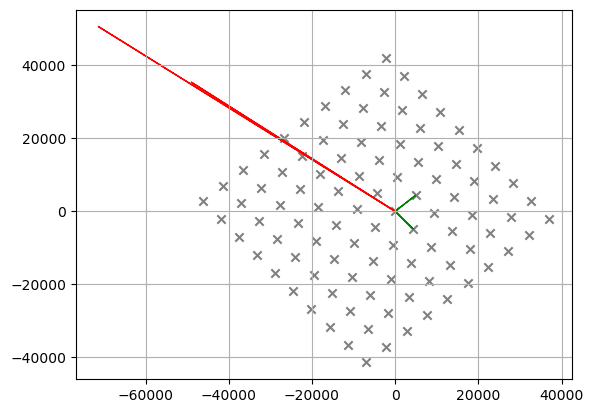

In [13]:
mini = 3000
maxi = 5000

# The next line gives you a random orthogonal 2x2 matrix where its entries are in the interval (mini,maxi)
V = orthogonal_2d_matrix(mini,maxi)
#V = matrix([[3,0],[0,3]])
#V = matrix([[601,600],[601,602]])


# The following line of code gives you a random unimodular matrix
# The function argument 'upper_bound=5' denotes that the max entries of this matrix will be at most 5
U = random_matrix(ZZ, 2, algorithm='unimodular', upper_bound=5000)
#U = matrix([[2,3],[3,5]])


# Calculate your bad basis from V and U
W = U*V

# We can print out the matrices
print_lattice_basis(V,U,W)

# We can check whether the Volumes of the lattices are equal to each other
# This is equal to showing that det(V) == det(W)
VolumeCheck_HadamardRatio(V,W)

# This plots the lattice and the basis vectors
plot_lattice(V,W)


## Encryption ## 


The chosen encoding variables are: 
Message m: [1 2]
Codeword Lattice point: [-169415  121325]
Error e: [0.200000000000000  1.00000000000000]
Ciphertext c: [-169414.800000000  121326.000000000]


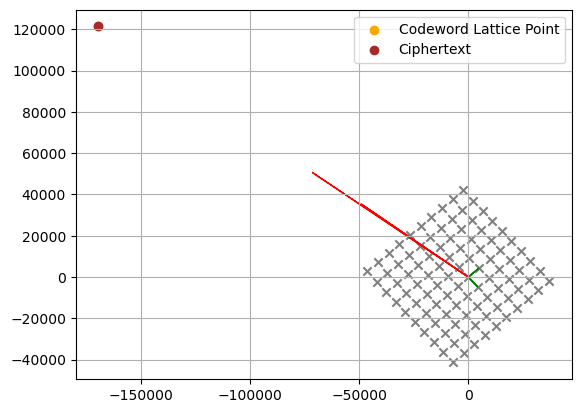

In [14]:
# Define a message 1x2 with small integer elements
message = [1,2]
m = matrix(message)

# Define the 1x2 error # Play around with the given error to see what happens
#r = [-2,3]
r = [0.2,1]
#r = [0.1,-0.1]
#r = [0, 0]
r = matrix(r)

# Define the ciphertext as a lattice point with some error added
cp = m*W
c = cp + r

# Print all the possible parameters
print_encoding_vars(m,r,cp,c)

# Now we can plot the lattice with the chosen ciphertext point
# Note you can adjust the amount of displayed lattice points with the 'minlim' and 'maxlim' function parameters (default is 'minlim=-5' and 'maxlim=5')
plot_lattice(V,W,c=c,cp=cp,minlim=-5,maxlim=5)


## Decryption ##


Decoding took us to: 
Point solved CVP with c using V: (-169415, 121325)
Decoded message using V: (1, 2)
Successful decoding with V!
Point solved CVP with c using W: (-169415, 121325)
Decoded message using W: (1, 2)
Successful decoding with W!!!
Check the Hadamard Ratio of W, the transformation matrix U or the error vector!


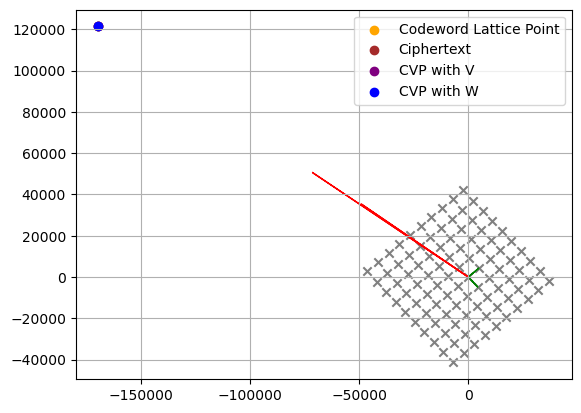

In [15]:
#--- Decode with the good basis

# We have to solve the CVP problem for the ciphertext c using the good basis

# We use the inverse of the good basis
cpr = c*V.inverse()
# Then we round the vector to the next integer
# Note that the function vecround does elementwise rounding of vector elements
c_hat = vecround(cpr)

# Now we can transfer the calculated vector to a lattice point again by multiplying with V again
c_hat_point = c_hat * V

# From that we can use the inverse of W to get to our message
m_hat = c_hat_point * W.inverse()


#--- Wrong Decoding
# We do the same with the bad basis W
c_wr = vecround(c*W.inverse())*W
m_wr = c_wr * W.inverse()

#Lets check if the decoded message was the same as the one before
printout_decode(c_hat_point,c_wr, m_hat, m_wr, vector(m))


# Now we can plot the CVP lattice points we calculated in the decoding step
# Note that you can adjust again the number of lattic points with minlim and maxlim
plot_lattice(V,W,c=c,cp=cp,chatp=c_hat_point,cwr=c_wr,minlim=-5,maxlim=5)


### Key Notes for Task 2 ###

- How wdoes a change in the magnitude of the error vector influences the decoding performance. Why does an error vector that is too large lead to a wrong decoding result?

  If the error is too large, the point that is closest to the ciphertext in the lattice is not the same point as the one before adding the error. Increasing the error will generally not change the decoding performance.
  
- Under which cirumstances will decoding with the 'bad' basis W be feasible? What's the connection to the Hadamard Ratio of W?

  The Hadamard ration provides an indicator of how orthogonal a basis is. The higher the Hadamard ratio, the more orthogonal the basis is. The bad basis should have a very low Hadamard ratio, all vectors of the basis should point in the same direction as close as possible (but the vectors should not be linearly dependent) and they should be very long. The decoding is going to be feasible if it is possible to find the closest vector to the ciphertext (including the error) with only the bad basis.